In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bell_Amundsen_Extent = pd.read_excel(filepath, sheet_name='Bell-Amundsen-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Bell_Amundsen_Extent)
fp.date_time(Bell_Amundsen_Extent)

,Extent,Date
0,1179855.894,1979-01-01
1,879585.254,1979-02-01
2,791619.096,1979-03-01
3,1254912.071,1979-04-01
4,1620142.247,1979-05-01
...,...,...
533,1556568.455,2023-06-01
534,1917507.979,2023-07-01
535,2601630.327,2023-08-01
536,2534223.780,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bell_Amundsen_Extent['Extent'] = scaler.fit_transform(Bell_Amundsen_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 4
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bell_Amundsen_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((523, 12, 1), (523,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bell_Amund_model_LT4/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 29s 387ms/step - loss: 0.2097 - root_mean_squared_error: 0.4579 - val_loss: 0.1397 - val_root_mean_squared_error: 0.3737
Epoch 2/50
53/53 [==============================] - 19s 369ms/step - loss: 0.0605 - root_mean_squared_error: 0.2459 - val_loss: 0.0583 - val_root_mean_squared_error: 0.2415
Epoch 3/50
53/53 [==============================] - 19s 374ms/step - loss: 0.0406 - root_mean_squared_error: 0.2014 - val_loss: 0.0498 - val_root_mean_squared_error: 0.2232
Epoch 4/50
53/53 [==============================] - 20s 375ms/step - loss: 0.0319 - root_mean_squared_error: 0.1786 - val_loss: 0.0374 - val_root_mean_squared_error: 0.1934
Epoch 5/50
53/53 [==============================] - 19s 367ms/step - loss: 0.0240 - root_mean_squared_error: 0.1548 - val_loss: 0.0287 - val_root_mean_squared_error: 0.1694
Epoch 6/50
53/53 [==============================] - 20s 388ms/step - loss: 0.0186 - root_mean_squared_error: 0.1365 - val_loss: 0.0258 

53/53 [==============================] - 19s 369ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993 - val_loss: 0.0164 - val_root_mean_squared_error: 0.1281
Epoch 30/50
53/53 [==============================] - 4s 68ms/step - loss: 0.0105 - root_mean_squared_error: 0.1027 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1291
Epoch 31/50
53/53 [==============================] - 3s 60ms/step - loss: 0.0100 - root_mean_squared_error: 0.1002 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1289
Epoch 32/50
53/53 [==============================] - 20s 380ms/step - loss: 0.0099 - root_mean_squared_error: 0.0996 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1266
Epoch 33/50
53/53 [==============================] - 3s 62ms/step - loss: 0.0097 - root_mean_squared_error: 0.0987 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1290
Epoch 34/50
53/53 [==============================] - 19s 371ms/step - loss: 0.0103 - root_mean_squared_error: 0.1013 - val_loss: 0.0160 - val_root_m

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

10.183300642172496 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

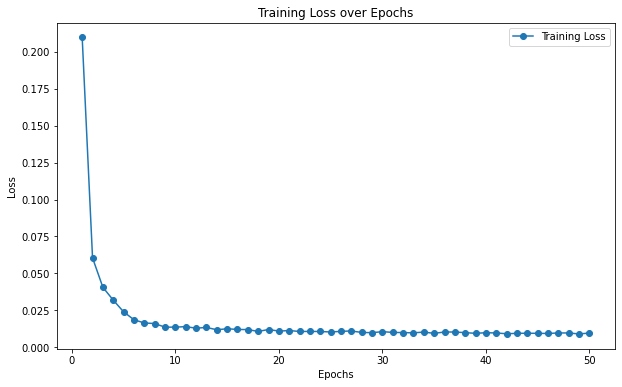

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

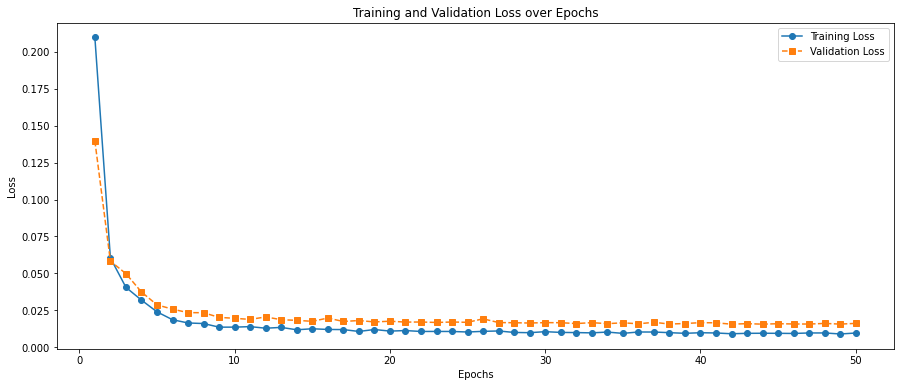

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bell_Amund_model_LT4/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 29ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.10537373647385093
MAE : 0.08595387057634137


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,2.264039e+06,2067343.547
1,2.305238e+06,1856673.675
2,2.153018e+06,1914289.680
3,1.869698e+06,1802244.842
4,1.420198e+06,1202791.069
5,8.578039e+05,752834.272
6,5.304767e+05,451914.219
7,5.727498e+05,439855.813
8,7.877444e+05,807857.307
9,1.116517e+06,1184280.145


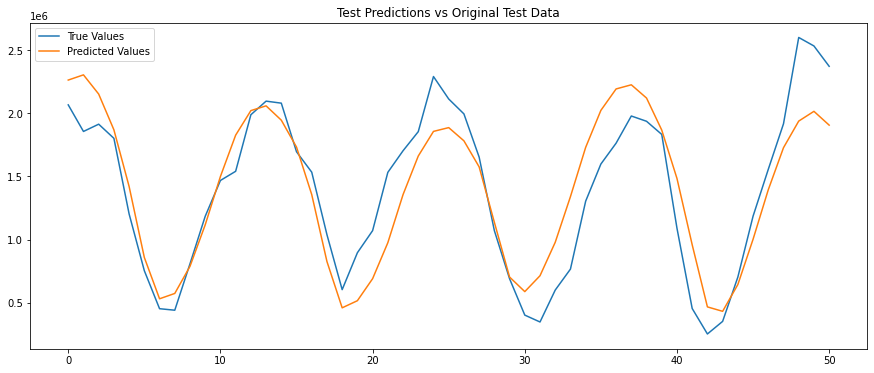

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 27ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

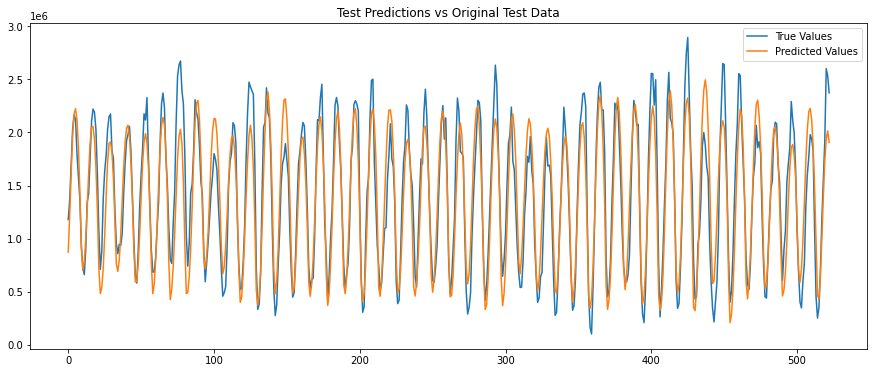

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()